<a href="https://colab.research.google.com/github/erichsiao1106/Gan/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [ ]:


class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10                                     #多餵一個分類的向量
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))                             #多一個類別(條件)
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)                                     # 要辨別的影像
        label = Input(shape=(1,), dtype='int32')                                 # 類別

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))        
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)      

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/%d.png" % epoch)
        plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

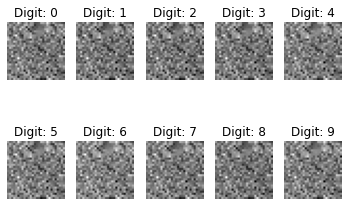

1 [D loss: 0.682877, acc.: 50.00%] [G loss: 0.672042]
2 [D loss: 0.674377, acc.: 50.00%] [G loss: 0.660630]
3 [D loss: 0.664150, acc.: 50.00%] [G loss: 0.653850]
4 [D loss: 0.655748, acc.: 50.00%] [G loss: 0.640929]
5 [D loss: 0.639824, acc.: 50.00%] [G loss: 0.636755]
6 [D loss: 0.629816, acc.: 50.00%] [G loss: 0.621524]
7 [D loss: 0.610450, acc.: 50.00%] [G loss: 0.614384]
8 [D loss: 0.587587, acc.: 50.00%] [G loss: 0.595839]
9 [D loss: 0.555650, acc.: 50.00%] [G loss: 0.591482]
10 [D loss: 0.525102, acc.: 51.56%] [G loss: 0.575478]
11 [D loss: 0.482324, acc.: 76.56%] [G loss: 0.551955]
12 [D loss: 0.450484, acc.: 87.50%] [G loss: 0.545329]
13 [D loss: 0.412195, acc.: 93.75%] [G loss: 0.534549]
14 [D loss: 0.386602, acc.: 90.62%] [G loss: 0.528791]
15 [D loss: 0.357098, acc.: 96.88%] [G loss: 0.510818]
16 [D loss: 0.320983, acc.: 100.00%] [G loss: 0.497140]
17 [D loss: 0.304747, acc.: 98.44%] [G loss: 0.545904]
18 [D loss: 0.276614, acc.: 100.00%] [G loss: 0.529116]
19 [D loss: 0.246

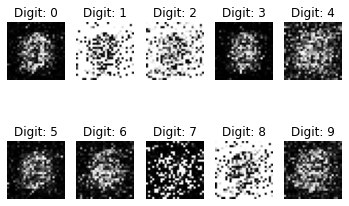

201 [D loss: 0.244479, acc.: 92.19%] [G loss: 4.202099]
202 [D loss: 0.585996, acc.: 73.44%] [G loss: 3.944321]
203 [D loss: 0.221959, acc.: 92.19%] [G loss: 4.115495]
204 [D loss: 0.231548, acc.: 92.19%] [G loss: 3.749225]
205 [D loss: 0.115149, acc.: 96.88%] [G loss: 3.404232]
206 [D loss: 0.368905, acc.: 79.69%] [G loss: 3.435307]
207 [D loss: 0.210413, acc.: 90.62%] [G loss: 3.992504]
208 [D loss: 0.236190, acc.: 89.06%] [G loss: 3.589995]
209 [D loss: 0.262941, acc.: 90.62%] [G loss: 4.135203]
210 [D loss: 0.384768, acc.: 79.69%] [G loss: 4.179420]
211 [D loss: 0.358165, acc.: 82.81%] [G loss: 3.349899]
212 [D loss: 0.533655, acc.: 76.56%] [G loss: 4.246925]
213 [D loss: 0.345824, acc.: 84.38%] [G loss: 3.814637]
214 [D loss: 0.258754, acc.: 93.75%] [G loss: 3.900043]
215 [D loss: 0.372094, acc.: 84.38%] [G loss: 3.284921]
216 [D loss: 0.405828, acc.: 82.81%] [G loss: 3.651407]
217 [D loss: 0.302752, acc.: 82.81%] [G loss: 3.671362]
218 [D loss: 0.341971, acc.: 82.81%] [G loss: 3.

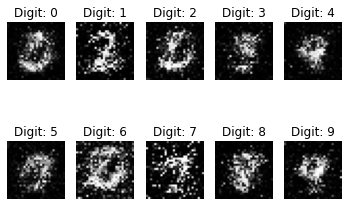

401 [D loss: 0.387409, acc.: 82.81%] [G loss: 2.348342]
402 [D loss: 0.485097, acc.: 78.12%] [G loss: 2.284783]
403 [D loss: 0.597504, acc.: 68.75%] [G loss: 2.036284]
404 [D loss: 0.357378, acc.: 89.06%] [G loss: 3.313702]
405 [D loss: 0.515268, acc.: 71.88%] [G loss: 2.162888]
406 [D loss: 0.367493, acc.: 81.25%] [G loss: 2.285638]
407 [D loss: 0.517213, acc.: 76.56%] [G loss: 2.242710]
408 [D loss: 0.518665, acc.: 75.00%] [G loss: 2.036518]
409 [D loss: 0.481491, acc.: 78.12%] [G loss: 2.856004]
410 [D loss: 0.481174, acc.: 84.38%] [G loss: 2.012199]
411 [D loss: 0.431900, acc.: 79.69%] [G loss: 2.214766]
412 [D loss: 0.465803, acc.: 79.69%] [G loss: 1.858964]
413 [D loss: 0.330118, acc.: 85.94%] [G loss: 2.452576]
414 [D loss: 0.422133, acc.: 82.81%] [G loss: 2.029498]
415 [D loss: 0.440196, acc.: 78.12%] [G loss: 2.459770]
416 [D loss: 0.358545, acc.: 87.50%] [G loss: 2.081841]
417 [D loss: 0.447866, acc.: 76.56%] [G loss: 2.628536]
418 [D loss: 0.460956, acc.: 78.12%] [G loss: 2.

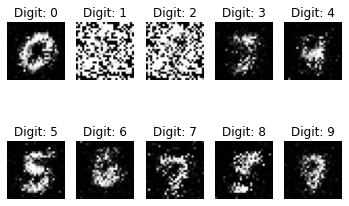

601 [D loss: 0.439725, acc.: 79.69%] [G loss: 2.050990]
602 [D loss: 0.493173, acc.: 76.56%] [G loss: 1.990518]
603 [D loss: 0.628539, acc.: 67.19%] [G loss: 1.661347]
604 [D loss: 0.440988, acc.: 84.38%] [G loss: 1.673731]
605 [D loss: 0.476575, acc.: 75.00%] [G loss: 1.953331]
606 [D loss: 0.415924, acc.: 81.25%] [G loss: 2.151884]
607 [D loss: 0.468700, acc.: 78.12%] [G loss: 1.868411]
608 [D loss: 0.407674, acc.: 82.81%] [G loss: 2.132190]
609 [D loss: 0.381178, acc.: 84.38%] [G loss: 2.230196]
610 [D loss: 0.720566, acc.: 64.06%] [G loss: 1.758162]
611 [D loss: 0.372122, acc.: 84.38%] [G loss: 1.739255]
612 [D loss: 0.519884, acc.: 76.56%] [G loss: 1.563399]
613 [D loss: 0.583633, acc.: 70.31%] [G loss: 1.807236]
614 [D loss: 0.439473, acc.: 75.00%] [G loss: 1.888685]
615 [D loss: 0.471802, acc.: 78.12%] [G loss: 1.821383]
616 [D loss: 0.614151, acc.: 64.06%] [G loss: 1.700496]
617 [D loss: 0.576898, acc.: 67.19%] [G loss: 1.691376]
618 [D loss: 0.431580, acc.: 76.56%] [G loss: 1.

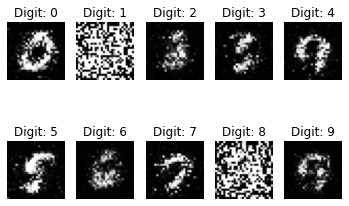

801 [D loss: 0.667449, acc.: 67.19%] [G loss: 1.785984]
802 [D loss: 0.509269, acc.: 71.88%] [G loss: 1.436458]
803 [D loss: 0.787599, acc.: 65.62%] [G loss: 1.553984]
804 [D loss: 0.714946, acc.: 59.38%] [G loss: 2.018390]
805 [D loss: 0.633305, acc.: 68.75%] [G loss: 1.689929]
806 [D loss: 0.599611, acc.: 68.75%] [G loss: 1.330767]
807 [D loss: 0.463389, acc.: 75.00%] [G loss: 1.399905]
808 [D loss: 0.503722, acc.: 75.00%] [G loss: 1.416653]
809 [D loss: 0.719227, acc.: 67.19%] [G loss: 1.472610]
810 [D loss: 0.493254, acc.: 73.44%] [G loss: 1.358380]
811 [D loss: 0.610477, acc.: 67.19%] [G loss: 1.632903]
812 [D loss: 0.559137, acc.: 68.75%] [G loss: 1.488112]
813 [D loss: 0.584061, acc.: 67.19%] [G loss: 1.678884]
814 [D loss: 0.560738, acc.: 70.31%] [G loss: 1.275699]
815 [D loss: 0.617882, acc.: 64.06%] [G loss: 1.455381]
816 [D loss: 0.502800, acc.: 78.12%] [G loss: 1.721148]
817 [D loss: 0.501696, acc.: 71.88%] [G loss: 1.273843]
818 [D loss: 0.633713, acc.: 65.62%] [G loss: 1.

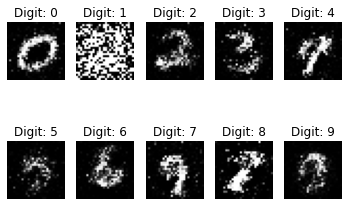

1001 [D loss: 0.600998, acc.: 65.62%] [G loss: 1.368211]
1002 [D loss: 0.595735, acc.: 67.19%] [G loss: 1.378790]
1003 [D loss: 0.584704, acc.: 68.75%] [G loss: 1.265925]
1004 [D loss: 0.538376, acc.: 76.56%] [G loss: 1.172811]
1005 [D loss: 0.529396, acc.: 73.44%] [G loss: 1.451857]
1006 [D loss: 0.628769, acc.: 65.62%] [G loss: 1.435087]
1007 [D loss: 0.559861, acc.: 73.44%] [G loss: 1.276602]
1008 [D loss: 0.493435, acc.: 75.00%] [G loss: 1.326060]
1009 [D loss: 0.577491, acc.: 70.31%] [G loss: 1.245194]
1010 [D loss: 0.576903, acc.: 68.75%] [G loss: 1.390637]
1011 [D loss: 0.645085, acc.: 62.50%] [G loss: 1.231924]
1012 [D loss: 0.601279, acc.: 65.62%] [G loss: 1.459224]
1013 [D loss: 0.638567, acc.: 71.88%] [G loss: 1.145014]
1014 [D loss: 0.492080, acc.: 78.12%] [G loss: 1.347606]
1015 [D loss: 0.570094, acc.: 67.19%] [G loss: 1.373938]
1016 [D loss: 0.563361, acc.: 70.31%] [G loss: 1.255824]
1017 [D loss: 0.616156, acc.: 64.06%] [G loss: 1.183764]
1018 [D loss: 0.559668, acc.: 7

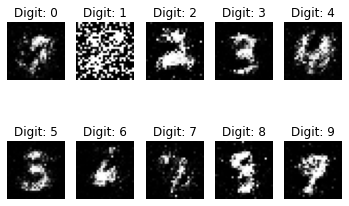

1201 [D loss: 0.622264, acc.: 67.19%] [G loss: 1.420471]
1202 [D loss: 0.604402, acc.: 71.88%] [G loss: 1.451826]
1203 [D loss: 0.602773, acc.: 65.62%] [G loss: 1.400364]
1204 [D loss: 0.632515, acc.: 65.62%] [G loss: 1.229319]
1205 [D loss: 0.545947, acc.: 75.00%] [G loss: 1.214886]
1206 [D loss: 0.572193, acc.: 67.19%] [G loss: 1.365375]
1207 [D loss: 0.507961, acc.: 78.12%] [G loss: 1.335227]
1208 [D loss: 0.647778, acc.: 60.94%] [G loss: 1.235027]
1209 [D loss: 0.560015, acc.: 68.75%] [G loss: 1.125107]
1210 [D loss: 0.623853, acc.: 62.50%] [G loss: 1.375969]
1211 [D loss: 0.618606, acc.: 60.94%] [G loss: 1.025386]
1212 [D loss: 0.541865, acc.: 70.31%] [G loss: 1.250932]
1213 [D loss: 0.577633, acc.: 64.06%] [G loss: 1.266421]
1214 [D loss: 0.680744, acc.: 68.75%] [G loss: 1.302154]
1215 [D loss: 0.641141, acc.: 67.19%] [G loss: 1.166645]
1216 [D loss: 0.569750, acc.: 71.88%] [G loss: 1.198306]
1217 [D loss: 0.585500, acc.: 64.06%] [G loss: 1.243698]
1218 [D loss: 0.594500, acc.: 7

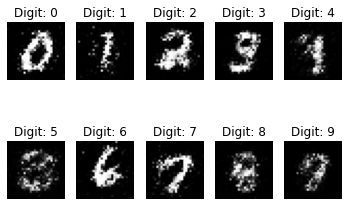

1401 [D loss: 0.729566, acc.: 53.12%] [G loss: 1.060581]
1402 [D loss: 0.669362, acc.: 59.38%] [G loss: 0.936426]
1403 [D loss: 0.682248, acc.: 60.94%] [G loss: 1.015206]
1404 [D loss: 0.705074, acc.: 60.94%] [G loss: 1.007456]
1405 [D loss: 0.695890, acc.: 60.94%] [G loss: 0.852461]
1406 [D loss: 0.696120, acc.: 59.38%] [G loss: 0.947018]
1407 [D loss: 0.679515, acc.: 59.38%] [G loss: 1.110005]
1408 [D loss: 0.616208, acc.: 68.75%] [G loss: 1.119875]
1409 [D loss: 0.610128, acc.: 68.75%] [G loss: 1.067239]
1410 [D loss: 0.693368, acc.: 60.94%] [G loss: 1.149718]
1411 [D loss: 0.681558, acc.: 56.25%] [G loss: 1.038091]
1412 [D loss: 0.618901, acc.: 67.19%] [G loss: 1.108533]
1413 [D loss: 0.638679, acc.: 65.62%] [G loss: 0.983966]
1414 [D loss: 0.621481, acc.: 64.06%] [G loss: 0.979759]
1415 [D loss: 0.656275, acc.: 62.50%] [G loss: 0.980892]
1416 [D loss: 0.662434, acc.: 62.50%] [G loss: 1.034846]
1417 [D loss: 0.673293, acc.: 54.69%] [G loss: 1.085811]
1418 [D loss: 0.650192, acc.: 6

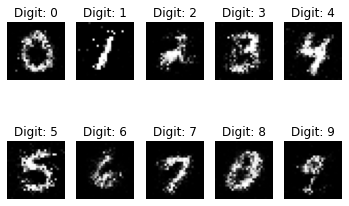

1601 [D loss: 0.654537, acc.: 56.25%] [G loss: 0.998476]
1602 [D loss: 0.620567, acc.: 68.75%] [G loss: 0.969157]
1603 [D loss: 0.715762, acc.: 43.75%] [G loss: 0.838871]
1604 [D loss: 0.689794, acc.: 54.69%] [G loss: 0.883627]
1605 [D loss: 0.679798, acc.: 59.38%] [G loss: 1.091337]
1606 [D loss: 0.672006, acc.: 57.81%] [G loss: 0.947596]
1607 [D loss: 0.645392, acc.: 57.81%] [G loss: 0.959291]
1608 [D loss: 0.598321, acc.: 68.75%] [G loss: 1.015650]
1609 [D loss: 0.671853, acc.: 64.06%] [G loss: 0.981271]
1610 [D loss: 0.648226, acc.: 59.38%] [G loss: 0.968210]
1611 [D loss: 0.630445, acc.: 59.38%] [G loss: 0.870105]
1612 [D loss: 0.640781, acc.: 60.94%] [G loss: 0.923296]
1613 [D loss: 0.686938, acc.: 54.69%] [G loss: 0.891660]
1614 [D loss: 0.620678, acc.: 62.50%] [G loss: 0.983422]
1615 [D loss: 0.651114, acc.: 59.38%] [G loss: 0.981063]
1616 [D loss: 0.640981, acc.: 64.06%] [G loss: 0.972423]
1617 [D loss: 0.584697, acc.: 70.31%] [G loss: 0.935644]
1618 [D loss: 0.633859, acc.: 6

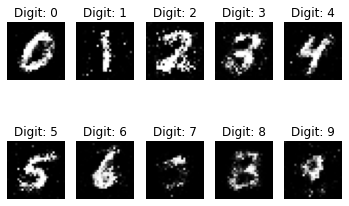

1801 [D loss: 0.649315, acc.: 57.81%] [G loss: 0.939801]
1802 [D loss: 0.615980, acc.: 70.31%] [G loss: 0.987642]
1803 [D loss: 0.683830, acc.: 56.25%] [G loss: 0.977427]
1804 [D loss: 0.633370, acc.: 65.62%] [G loss: 0.948700]
1805 [D loss: 0.633556, acc.: 57.81%] [G loss: 1.035114]
1806 [D loss: 0.624042, acc.: 60.94%] [G loss: 1.063967]
1807 [D loss: 0.645156, acc.: 57.81%] [G loss: 0.956496]
1808 [D loss: 0.719165, acc.: 54.69%] [G loss: 0.937647]
1809 [D loss: 0.601734, acc.: 64.06%] [G loss: 0.960989]
1810 [D loss: 0.657312, acc.: 53.12%] [G loss: 0.986028]
1811 [D loss: 0.555194, acc.: 71.88%] [G loss: 0.884025]
1812 [D loss: 0.592915, acc.: 67.19%] [G loss: 1.037789]
1813 [D loss: 0.707160, acc.: 51.56%] [G loss: 0.944597]
1814 [D loss: 0.606538, acc.: 70.31%] [G loss: 0.955109]
1815 [D loss: 0.658955, acc.: 51.56%] [G loss: 0.943357]
1816 [D loss: 0.623875, acc.: 67.19%] [G loss: 0.935795]
1817 [D loss: 0.718475, acc.: 51.56%] [G loss: 0.938154]
1818 [D loss: 0.602597, acc.: 6

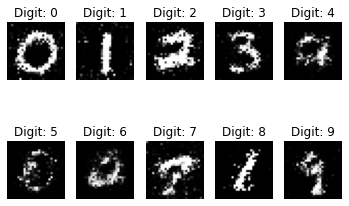

2001 [D loss: 0.623901, acc.: 70.31%] [G loss: 0.832680]
2002 [D loss: 0.618782, acc.: 67.19%] [G loss: 0.865566]
2003 [D loss: 0.708949, acc.: 48.44%] [G loss: 0.905373]
2004 [D loss: 0.686868, acc.: 53.12%] [G loss: 0.856649]
2005 [D loss: 0.641968, acc.: 67.19%] [G loss: 0.886760]
2006 [D loss: 0.643978, acc.: 68.75%] [G loss: 0.902603]
2007 [D loss: 0.671019, acc.: 57.81%] [G loss: 0.888740]
2008 [D loss: 0.633075, acc.: 70.31%] [G loss: 0.894322]
2009 [D loss: 0.677656, acc.: 54.69%] [G loss: 0.900780]
2010 [D loss: 0.662143, acc.: 59.38%] [G loss: 0.931959]
2011 [D loss: 0.672469, acc.: 53.12%] [G loss: 0.870992]
2012 [D loss: 0.635428, acc.: 60.94%] [G loss: 0.912412]
2013 [D loss: 0.677583, acc.: 56.25%] [G loss: 0.978556]
2014 [D loss: 0.693789, acc.: 51.56%] [G loss: 0.903149]
2015 [D loss: 0.651448, acc.: 59.38%] [G loss: 0.914551]
2016 [D loss: 0.643470, acc.: 59.38%] [G loss: 0.965489]
2017 [D loss: 0.623399, acc.: 60.94%] [G loss: 0.892579]
2018 [D loss: 0.660707, acc.: 5

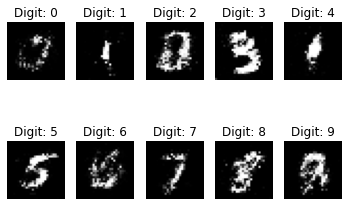

2201 [D loss: 0.625924, acc.: 65.62%] [G loss: 0.891323]
2202 [D loss: 0.713780, acc.: 50.00%] [G loss: 0.838811]
2203 [D loss: 0.677418, acc.: 56.25%] [G loss: 0.882285]
2204 [D loss: 0.672052, acc.: 54.69%] [G loss: 0.767330]
2205 [D loss: 0.665867, acc.: 60.94%] [G loss: 0.851504]
2206 [D loss: 0.688616, acc.: 50.00%] [G loss: 0.860045]
2207 [D loss: 0.669428, acc.: 59.38%] [G loss: 0.887528]
2208 [D loss: 0.625563, acc.: 71.88%] [G loss: 0.846958]
2209 [D loss: 0.648043, acc.: 60.94%] [G loss: 0.848832]
2210 [D loss: 0.697003, acc.: 53.12%] [G loss: 0.865901]
2211 [D loss: 0.627880, acc.: 68.75%] [G loss: 0.892826]
2212 [D loss: 0.628484, acc.: 67.19%] [G loss: 0.844829]
2213 [D loss: 0.679937, acc.: 56.25%] [G loss: 0.906204]
2214 [D loss: 0.669006, acc.: 60.94%] [G loss: 0.865689]
2215 [D loss: 0.655338, acc.: 62.50%] [G loss: 0.907246]
2216 [D loss: 0.639896, acc.: 60.94%] [G loss: 0.822034]
2217 [D loss: 0.649855, acc.: 67.19%] [G loss: 0.849917]
2218 [D loss: 0.665068, acc.: 6

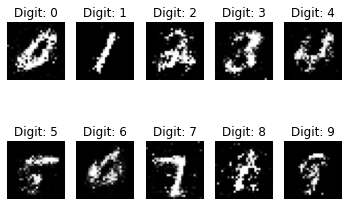

2401 [D loss: 0.647093, acc.: 57.81%] [G loss: 0.859708]
2402 [D loss: 0.636244, acc.: 60.94%] [G loss: 0.919806]
2403 [D loss: 0.667960, acc.: 50.00%] [G loss: 0.846917]
2404 [D loss: 0.632823, acc.: 64.06%] [G loss: 0.816718]
2405 [D loss: 0.627629, acc.: 62.50%] [G loss: 0.899848]
2406 [D loss: 0.621561, acc.: 64.06%] [G loss: 0.861123]
2407 [D loss: 0.597795, acc.: 70.31%] [G loss: 0.858843]
2408 [D loss: 0.685776, acc.: 53.12%] [G loss: 0.902581]
2409 [D loss: 0.645055, acc.: 54.69%] [G loss: 0.908293]
2410 [D loss: 0.659601, acc.: 59.38%] [G loss: 1.006611]
2411 [D loss: 0.655618, acc.: 54.69%] [G loss: 0.931577]
2412 [D loss: 0.746352, acc.: 50.00%] [G loss: 0.953494]
2413 [D loss: 0.728554, acc.: 51.56%] [G loss: 0.919546]
2414 [D loss: 0.641970, acc.: 67.19%] [G loss: 0.926737]
2415 [D loss: 0.662927, acc.: 54.69%] [G loss: 0.861284]
2416 [D loss: 0.626359, acc.: 57.81%] [G loss: 0.911536]
2417 [D loss: 0.666666, acc.: 57.81%] [G loss: 0.903861]
2418 [D loss: 0.679011, acc.: 5

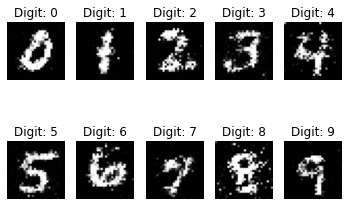

2601 [D loss: 0.682272, acc.: 51.56%] [G loss: 0.884495]
2602 [D loss: 0.664287, acc.: 56.25%] [G loss: 0.878195]
2603 [D loss: 0.699613, acc.: 57.81%] [G loss: 0.844720]
2604 [D loss: 0.652825, acc.: 60.94%] [G loss: 0.842764]
2605 [D loss: 0.668687, acc.: 50.00%] [G loss: 0.865916]
2606 [D loss: 0.613299, acc.: 65.62%] [G loss: 0.898399]
2607 [D loss: 0.633492, acc.: 57.81%] [G loss: 0.907079]
2608 [D loss: 0.658841, acc.: 56.25%] [G loss: 0.846490]
2609 [D loss: 0.681129, acc.: 56.25%] [G loss: 0.927509]
2610 [D loss: 0.653657, acc.: 59.38%] [G loss: 0.876119]
2611 [D loss: 0.694424, acc.: 54.69%] [G loss: 0.864414]
2612 [D loss: 0.668320, acc.: 57.81%] [G loss: 0.941915]
2613 [D loss: 0.653770, acc.: 54.69%] [G loss: 0.879672]
2614 [D loss: 0.624976, acc.: 64.06%] [G loss: 0.897842]
2615 [D loss: 0.667891, acc.: 60.94%] [G loss: 0.811678]
2616 [D loss: 0.655331, acc.: 57.81%] [G loss: 0.853741]
2617 [D loss: 0.689173, acc.: 57.81%] [G loss: 0.830106]
2618 [D loss: 0.681005, acc.: 5

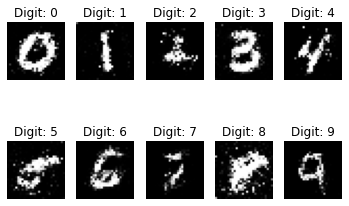

2801 [D loss: 0.635418, acc.: 65.62%] [G loss: 0.813788]
2802 [D loss: 0.694176, acc.: 54.69%] [G loss: 0.820359]
2803 [D loss: 0.698291, acc.: 53.12%] [G loss: 0.877812]
2804 [D loss: 0.639136, acc.: 71.88%] [G loss: 0.842508]
2805 [D loss: 0.680710, acc.: 53.12%] [G loss: 0.794251]
2806 [D loss: 0.616969, acc.: 71.88%] [G loss: 0.802702]
2807 [D loss: 0.724105, acc.: 51.56%] [G loss: 0.854064]
2808 [D loss: 0.685475, acc.: 62.50%] [G loss: 0.838339]
2809 [D loss: 0.690466, acc.: 51.56%] [G loss: 0.833068]
2810 [D loss: 0.618628, acc.: 62.50%] [G loss: 0.833280]
2811 [D loss: 0.658604, acc.: 54.69%] [G loss: 0.860463]
2812 [D loss: 0.624350, acc.: 65.62%] [G loss: 0.858020]
2813 [D loss: 0.629244, acc.: 68.75%] [G loss: 0.853817]
2814 [D loss: 0.686121, acc.: 56.25%] [G loss: 0.793165]
2815 [D loss: 0.647573, acc.: 56.25%] [G loss: 0.825179]
2816 [D loss: 0.622717, acc.: 71.88%] [G loss: 0.802917]
2817 [D loss: 0.670096, acc.: 57.81%] [G loss: 0.807023]
2818 [D loss: 0.632354, acc.: 6

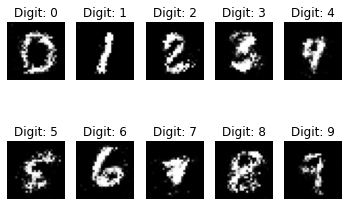

3001 [D loss: 0.666747, acc.: 59.38%] [G loss: 0.813381]
3002 [D loss: 0.694275, acc.: 51.56%] [G loss: 0.814509]
3003 [D loss: 0.678019, acc.: 56.25%] [G loss: 0.825032]
3004 [D loss: 0.654898, acc.: 64.06%] [G loss: 0.793868]
3005 [D loss: 0.656589, acc.: 60.94%] [G loss: 0.801785]
3006 [D loss: 0.685378, acc.: 54.69%] [G loss: 0.845056]
3007 [D loss: 0.641837, acc.: 59.38%] [G loss: 0.803978]
3008 [D loss: 0.701402, acc.: 53.12%] [G loss: 0.838104]
3009 [D loss: 0.671026, acc.: 57.81%] [G loss: 0.828422]
3010 [D loss: 0.651536, acc.: 54.69%] [G loss: 0.810596]
3011 [D loss: 0.673644, acc.: 54.69%] [G loss: 0.848163]
3012 [D loss: 0.671646, acc.: 54.69%] [G loss: 0.816832]
3013 [D loss: 0.641551, acc.: 64.06%] [G loss: 0.829267]
3014 [D loss: 0.672545, acc.: 56.25%] [G loss: 0.774805]
3015 [D loss: 0.672713, acc.: 54.69%] [G loss: 0.783022]
3016 [D loss: 0.675805, acc.: 57.81%] [G loss: 0.785627]
3017 [D loss: 0.650311, acc.: 57.81%] [G loss: 0.792899]
3018 [D loss: 0.707055, acc.: 5

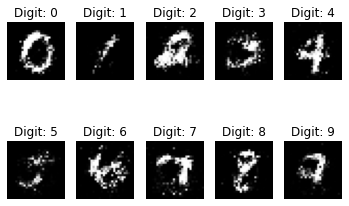

3201 [D loss: 0.663559, acc.: 56.25%] [G loss: 0.825331]
3202 [D loss: 0.694651, acc.: 60.94%] [G loss: 0.857620]
3203 [D loss: 0.655907, acc.: 56.25%] [G loss: 0.787677]
3204 [D loss: 0.704754, acc.: 62.50%] [G loss: 0.828984]
3205 [D loss: 0.658842, acc.: 67.19%] [G loss: 0.762780]
3206 [D loss: 0.706080, acc.: 56.25%] [G loss: 0.809581]
3207 [D loss: 0.675599, acc.: 62.50%] [G loss: 0.817932]
3208 [D loss: 0.670067, acc.: 65.62%] [G loss: 0.801235]
3209 [D loss: 0.659883, acc.: 59.38%] [G loss: 0.806122]
3210 [D loss: 0.676865, acc.: 50.00%] [G loss: 0.786392]
3211 [D loss: 0.649603, acc.: 59.38%] [G loss: 0.814323]
3212 [D loss: 0.648044, acc.: 59.38%] [G loss: 0.793391]
3213 [D loss: 0.685785, acc.: 53.12%] [G loss: 0.802859]
3214 [D loss: 0.666484, acc.: 60.94%] [G loss: 0.842430]
3215 [D loss: 0.696549, acc.: 57.81%] [G loss: 0.815961]
3216 [D loss: 0.635456, acc.: 64.06%] [G loss: 0.904211]
3217 [D loss: 0.663338, acc.: 56.25%] [G loss: 0.895876]
3218 [D loss: 0.657814, acc.: 6

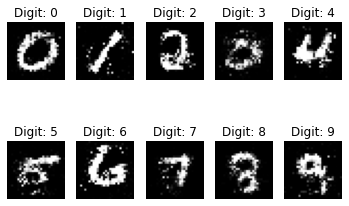

3401 [D loss: 0.708151, acc.: 48.44%] [G loss: 0.884279]
3402 [D loss: 0.676686, acc.: 54.69%] [G loss: 0.848295]
3403 [D loss: 0.615905, acc.: 60.94%] [G loss: 0.872607]
3404 [D loss: 0.677213, acc.: 56.25%] [G loss: 0.817889]
3405 [D loss: 0.643144, acc.: 64.06%] [G loss: 0.829136]
3406 [D loss: 0.691464, acc.: 50.00%] [G loss: 0.807013]
3407 [D loss: 0.636478, acc.: 68.75%] [G loss: 0.833437]
3408 [D loss: 0.704543, acc.: 50.00%] [G loss: 0.812601]
3409 [D loss: 0.684999, acc.: 51.56%] [G loss: 0.801255]
3410 [D loss: 0.674664, acc.: 59.38%] [G loss: 0.809755]
3411 [D loss: 0.712248, acc.: 57.81%] [G loss: 0.830439]
3412 [D loss: 0.675867, acc.: 51.56%] [G loss: 0.815560]
3413 [D loss: 0.669713, acc.: 51.56%] [G loss: 0.872957]
3414 [D loss: 0.630499, acc.: 60.94%] [G loss: 0.854487]
3415 [D loss: 0.679245, acc.: 54.69%] [G loss: 0.812815]
3416 [D loss: 0.653594, acc.: 62.50%] [G loss: 0.805328]
3417 [D loss: 0.660570, acc.: 59.38%] [G loss: 0.826691]
3418 [D loss: 0.644297, acc.: 5

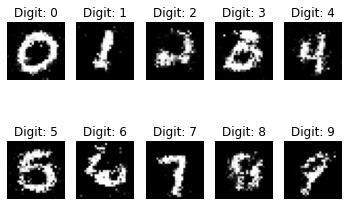

3601 [D loss: 0.672990, acc.: 59.38%] [G loss: 0.772981]
3602 [D loss: 0.689347, acc.: 51.56%] [G loss: 0.776181]
3603 [D loss: 0.676192, acc.: 57.81%] [G loss: 0.779353]
3604 [D loss: 0.681401, acc.: 59.38%] [G loss: 0.801439]
3605 [D loss: 0.650584, acc.: 60.94%] [G loss: 0.787091]
3606 [D loss: 0.694192, acc.: 53.12%] [G loss: 0.783190]
3607 [D loss: 0.669464, acc.: 59.38%] [G loss: 0.776829]
3608 [D loss: 0.683245, acc.: 51.56%] [G loss: 0.772004]
3609 [D loss: 0.658594, acc.: 59.38%] [G loss: 0.751033]
3610 [D loss: 0.678992, acc.: 54.69%] [G loss: 0.781225]
3611 [D loss: 0.674318, acc.: 53.12%] [G loss: 0.789499]
3612 [D loss: 0.673305, acc.: 64.06%] [G loss: 0.742100]
3613 [D loss: 0.696361, acc.: 51.56%] [G loss: 0.741313]
3614 [D loss: 0.702052, acc.: 43.75%] [G loss: 0.806844]
3615 [D loss: 0.695671, acc.: 51.56%] [G loss: 0.830298]
3616 [D loss: 0.621789, acc.: 75.00%] [G loss: 0.847733]
3617 [D loss: 0.674692, acc.: 51.56%] [G loss: 0.751323]
3618 [D loss: 0.638551, acc.: 5

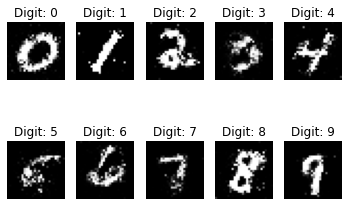

3801 [D loss: 0.683891, acc.: 53.12%] [G loss: 0.733485]
3802 [D loss: 0.689865, acc.: 50.00%] [G loss: 0.797977]
3803 [D loss: 0.703453, acc.: 40.62%] [G loss: 0.861553]
3804 [D loss: 0.661566, acc.: 57.81%] [G loss: 0.821789]
3805 [D loss: 0.659451, acc.: 57.81%] [G loss: 0.823524]
3806 [D loss: 0.677486, acc.: 54.69%] [G loss: 0.872797]
3807 [D loss: 0.670711, acc.: 53.12%] [G loss: 0.797778]
3808 [D loss: 0.694130, acc.: 50.00%] [G loss: 0.799630]
3809 [D loss: 0.684212, acc.: 43.75%] [G loss: 0.815847]
3810 [D loss: 0.668116, acc.: 68.75%] [G loss: 0.835087]
3811 [D loss: 0.668189, acc.: 53.12%] [G loss: 0.795031]
3812 [D loss: 0.662632, acc.: 59.38%] [G loss: 0.814522]
3813 [D loss: 0.685921, acc.: 59.38%] [G loss: 0.832906]
3814 [D loss: 0.656804, acc.: 57.81%] [G loss: 0.770971]
3815 [D loss: 0.675494, acc.: 51.56%] [G loss: 0.772651]
3816 [D loss: 0.641132, acc.: 60.94%] [G loss: 0.796263]
3817 [D loss: 0.629313, acc.: 68.75%] [G loss: 0.791462]
3818 [D loss: 0.669942, acc.: 5

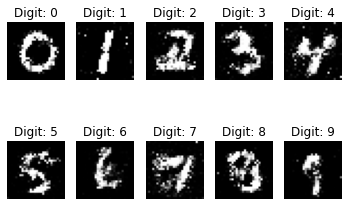

4001 [D loss: 0.700045, acc.: 53.12%] [G loss: 0.804778]
4002 [D loss: 0.678163, acc.: 60.94%] [G loss: 0.827424]
4003 [D loss: 0.715370, acc.: 46.88%] [G loss: 0.807323]
4004 [D loss: 0.711091, acc.: 43.75%] [G loss: 0.828145]
4005 [D loss: 0.687610, acc.: 56.25%] [G loss: 0.823081]
4006 [D loss: 0.667123, acc.: 60.94%] [G loss: 0.799872]
4007 [D loss: 0.690203, acc.: 56.25%] [G loss: 0.769100]
4008 [D loss: 0.647480, acc.: 59.38%] [G loss: 0.795271]
4009 [D loss: 0.706301, acc.: 51.56%] [G loss: 0.809760]
4010 [D loss: 0.716908, acc.: 46.88%] [G loss: 0.769450]
4011 [D loss: 0.686986, acc.: 57.81%] [G loss: 0.809917]
4012 [D loss: 0.698265, acc.: 46.88%] [G loss: 0.820995]
4013 [D loss: 0.649888, acc.: 59.38%] [G loss: 0.827574]
4014 [D loss: 0.677590, acc.: 46.88%] [G loss: 0.802958]
4015 [D loss: 0.665067, acc.: 59.38%] [G loss: 0.826359]
4016 [D loss: 0.664757, acc.: 59.38%] [G loss: 0.801215]
4017 [D loss: 0.671564, acc.: 46.88%] [G loss: 0.786559]
4018 [D loss: 0.634317, acc.: 6

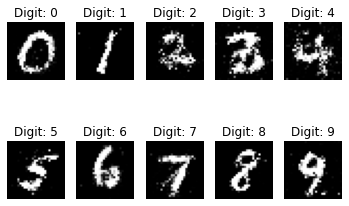

4201 [D loss: 0.645549, acc.: 65.62%] [G loss: 0.796587]
4202 [D loss: 0.663016, acc.: 57.81%] [G loss: 0.811575]
4203 [D loss: 0.753403, acc.: 42.19%] [G loss: 0.804349]
4204 [D loss: 0.694412, acc.: 50.00%] [G loss: 0.803694]
4205 [D loss: 0.669531, acc.: 57.81%] [G loss: 0.795604]
4206 [D loss: 0.652423, acc.: 65.62%] [G loss: 0.774159]
4207 [D loss: 0.717162, acc.: 48.44%] [G loss: 0.808078]
4208 [D loss: 0.658133, acc.: 59.38%] [G loss: 0.817533]
4209 [D loss: 0.674516, acc.: 56.25%] [G loss: 0.829653]
4210 [D loss: 0.651552, acc.: 64.06%] [G loss: 0.788099]
4211 [D loss: 0.662672, acc.: 56.25%] [G loss: 0.764252]
4212 [D loss: 0.642144, acc.: 65.62%] [G loss: 0.748539]
4213 [D loss: 0.728231, acc.: 46.88%] [G loss: 0.768113]
4214 [D loss: 0.621688, acc.: 68.75%] [G loss: 0.833260]
4215 [D loss: 0.688932, acc.: 53.12%] [G loss: 0.800196]
4216 [D loss: 0.629255, acc.: 67.19%] [G loss: 0.771048]
4217 [D loss: 0.663419, acc.: 57.81%] [G loss: 0.771834]
4218 [D loss: 0.737624, acc.: 5

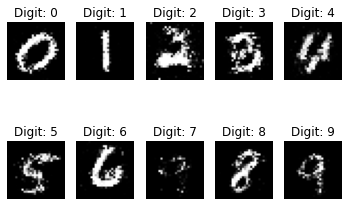

4401 [D loss: 0.693645, acc.: 50.00%] [G loss: 0.793034]
4402 [D loss: 0.672202, acc.: 57.81%] [G loss: 0.751463]
4403 [D loss: 0.674210, acc.: 54.69%] [G loss: 0.799468]
4404 [D loss: 0.732352, acc.: 50.00%] [G loss: 0.829862]
4405 [D loss: 0.643143, acc.: 64.06%] [G loss: 0.760178]
4406 [D loss: 0.699640, acc.: 46.88%] [G loss: 0.808206]
4407 [D loss: 0.640932, acc.: 62.50%] [G loss: 0.837228]
4408 [D loss: 0.708240, acc.: 56.25%] [G loss: 0.793838]
4409 [D loss: 0.642590, acc.: 64.06%] [G loss: 0.788358]
4410 [D loss: 0.710032, acc.: 45.31%] [G loss: 0.819899]
4411 [D loss: 0.658223, acc.: 59.38%] [G loss: 0.803243]
4412 [D loss: 0.657155, acc.: 62.50%] [G loss: 0.784191]
4413 [D loss: 0.667122, acc.: 60.94%] [G loss: 0.782327]
4414 [D loss: 0.659753, acc.: 65.62%] [G loss: 0.777792]
4415 [D loss: 0.663951, acc.: 57.81%] [G loss: 0.765346]
4416 [D loss: 0.690138, acc.: 59.38%] [G loss: 0.779038]
4417 [D loss: 0.679620, acc.: 51.56%] [G loss: 0.782976]
4418 [D loss: 0.675004, acc.: 5

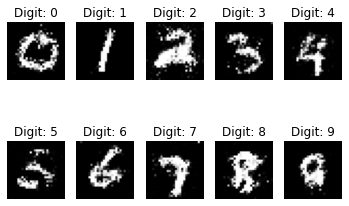

4601 [D loss: 0.682613, acc.: 51.56%] [G loss: 0.850981]
4602 [D loss: 0.659594, acc.: 51.56%] [G loss: 0.808513]
4603 [D loss: 0.663262, acc.: 56.25%] [G loss: 0.847372]
4604 [D loss: 0.697737, acc.: 43.75%] [G loss: 0.877297]
4605 [D loss: 0.636766, acc.: 59.38%] [G loss: 0.815881]
4606 [D loss: 0.677333, acc.: 57.81%] [G loss: 0.856465]
4607 [D loss: 0.661796, acc.: 56.25%] [G loss: 0.799454]
4608 [D loss: 0.668344, acc.: 59.38%] [G loss: 0.811340]
4609 [D loss: 0.636340, acc.: 60.94%] [G loss: 0.833834]
4610 [D loss: 0.642847, acc.: 68.75%] [G loss: 0.784610]
4611 [D loss: 0.649027, acc.: 60.94%] [G loss: 0.794616]
4612 [D loss: 0.711697, acc.: 42.19%] [G loss: 0.844018]
4613 [D loss: 0.644974, acc.: 60.94%] [G loss: 0.772891]
4614 [D loss: 0.628464, acc.: 60.94%] [G loss: 0.827737]
4615 [D loss: 0.640236, acc.: 62.50%] [G loss: 0.768197]
4616 [D loss: 0.607370, acc.: 62.50%] [G loss: 0.890790]
4617 [D loss: 0.640505, acc.: 64.06%] [G loss: 0.793756]
4618 [D loss: 0.648440, acc.: 5

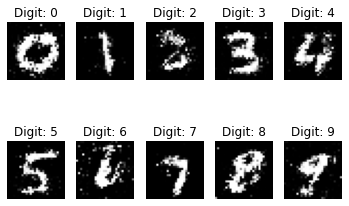

4801 [D loss: 0.686159, acc.: 50.00%] [G loss: 0.759503]
4802 [D loss: 0.672057, acc.: 57.81%] [G loss: 0.789117]
4803 [D loss: 0.667830, acc.: 60.94%] [G loss: 0.854262]
4804 [D loss: 0.683494, acc.: 53.12%] [G loss: 0.825378]
4805 [D loss: 0.703053, acc.: 48.44%] [G loss: 0.814214]
4806 [D loss: 0.662585, acc.: 60.94%] [G loss: 0.777187]
4807 [D loss: 0.665598, acc.: 62.50%] [G loss: 0.818634]
4808 [D loss: 0.649972, acc.: 59.38%] [G loss: 0.780765]
4809 [D loss: 0.697668, acc.: 56.25%] [G loss: 0.751361]
4810 [D loss: 0.704173, acc.: 42.19%] [G loss: 0.757711]
4811 [D loss: 0.631933, acc.: 62.50%] [G loss: 0.780598]
4812 [D loss: 0.659357, acc.: 56.25%] [G loss: 0.768740]
4813 [D loss: 0.699922, acc.: 53.12%] [G loss: 0.716267]
4814 [D loss: 0.657386, acc.: 59.38%] [G loss: 0.780554]
4815 [D loss: 0.616264, acc.: 65.62%] [G loss: 0.842715]
4816 [D loss: 0.680102, acc.: 56.25%] [G loss: 0.844104]
4817 [D loss: 0.683947, acc.: 50.00%] [G loss: 0.831711]
4818 [D loss: 0.634968, acc.: 6

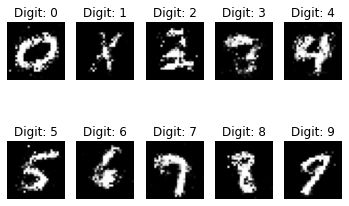

5001 [D loss: 0.669285, acc.: 51.56%] [G loss: 0.805044]
5002 [D loss: 0.680925, acc.: 50.00%] [G loss: 0.851547]
5003 [D loss: 0.655852, acc.: 57.81%] [G loss: 0.803348]
5004 [D loss: 0.684206, acc.: 48.44%] [G loss: 0.791872]
5005 [D loss: 0.647595, acc.: 54.69%] [G loss: 0.765776]
5006 [D loss: 0.695202, acc.: 53.12%] [G loss: 0.795798]
5007 [D loss: 0.707231, acc.: 48.44%] [G loss: 0.796126]
5008 [D loss: 0.655801, acc.: 57.81%] [G loss: 0.817597]
5009 [D loss: 0.671792, acc.: 57.81%] [G loss: 0.806084]
5010 [D loss: 0.679085, acc.: 51.56%] [G loss: 0.849582]
5011 [D loss: 0.679700, acc.: 53.12%] [G loss: 0.798284]
5012 [D loss: 0.674143, acc.: 51.56%] [G loss: 0.784594]
5013 [D loss: 0.669964, acc.: 54.69%] [G loss: 0.756094]
5014 [D loss: 0.685740, acc.: 53.12%] [G loss: 0.789187]
5015 [D loss: 0.666544, acc.: 53.12%] [G loss: 0.807676]
5016 [D loss: 0.688254, acc.: 56.25%] [G loss: 0.818877]
5017 [D loss: 0.650411, acc.: 64.06%] [G loss: 0.827466]
5018 [D loss: 0.705923, acc.: 4

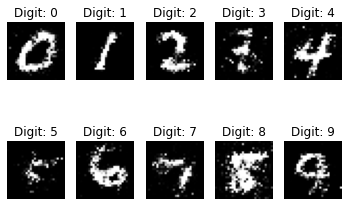

5201 [D loss: 0.661465, acc.: 56.25%] [G loss: 0.805921]
5202 [D loss: 0.694052, acc.: 53.12%] [G loss: 0.771474]
5203 [D loss: 0.657609, acc.: 57.81%] [G loss: 0.789514]
5204 [D loss: 0.664045, acc.: 53.12%] [G loss: 0.788585]
5205 [D loss: 0.721177, acc.: 53.12%] [G loss: 0.795454]
5206 [D loss: 0.702140, acc.: 51.56%] [G loss: 0.771799]
5207 [D loss: 0.660319, acc.: 59.38%] [G loss: 0.809251]
5208 [D loss: 0.687563, acc.: 50.00%] [G loss: 0.758846]
5209 [D loss: 0.663671, acc.: 56.25%] [G loss: 0.757267]
5210 [D loss: 0.669325, acc.: 53.12%] [G loss: 0.755229]
5211 [D loss: 0.659479, acc.: 53.12%] [G loss: 0.770028]
5212 [D loss: 0.671163, acc.: 53.12%] [G loss: 0.775859]
5213 [D loss: 0.664546, acc.: 57.81%] [G loss: 0.772021]
5214 [D loss: 0.720730, acc.: 50.00%] [G loss: 0.779709]
5215 [D loss: 0.717592, acc.: 53.12%] [G loss: 0.775001]
5216 [D loss: 0.695458, acc.: 50.00%] [G loss: 0.778193]
5217 [D loss: 0.678720, acc.: 57.81%] [G loss: 0.757523]
5218 [D loss: 0.688306, acc.: 4

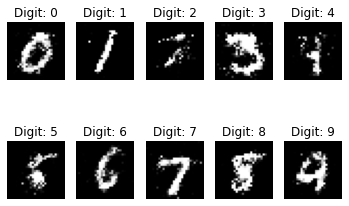

5401 [D loss: 0.725999, acc.: 50.00%] [G loss: 0.858154]
5402 [D loss: 0.666302, acc.: 60.94%] [G loss: 0.765560]
5403 [D loss: 0.652771, acc.: 59.38%] [G loss: 0.852877]
5404 [D loss: 0.723242, acc.: 51.56%] [G loss: 0.825335]
5405 [D loss: 0.681430, acc.: 57.81%] [G loss: 0.856596]
5406 [D loss: 0.683982, acc.: 53.12%] [G loss: 0.799773]
5407 [D loss: 0.694366, acc.: 53.12%] [G loss: 0.792850]
5408 [D loss: 0.669122, acc.: 65.62%] [G loss: 0.809608]
5409 [D loss: 0.651517, acc.: 64.06%] [G loss: 0.755273]
5410 [D loss: 0.679006, acc.: 64.06%] [G loss: 0.806094]
5411 [D loss: 0.652128, acc.: 56.25%] [G loss: 0.799173]
5412 [D loss: 0.717802, acc.: 56.25%] [G loss: 0.779416]
5413 [D loss: 0.652425, acc.: 60.94%] [G loss: 0.861830]
5414 [D loss: 0.705860, acc.: 56.25%] [G loss: 0.796920]
5415 [D loss: 0.658909, acc.: 57.81%] [G loss: 0.816148]
5416 [D loss: 0.653635, acc.: 57.81%] [G loss: 0.803011]
5417 [D loss: 0.678180, acc.: 53.12%] [G loss: 0.762311]
5418 [D loss: 0.654695, acc.: 6

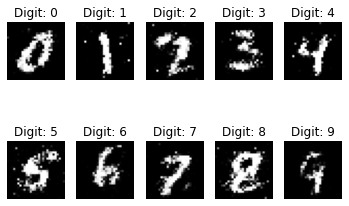

5601 [D loss: 0.718220, acc.: 51.56%] [G loss: 0.723524]
5602 [D loss: 0.646903, acc.: 57.81%] [G loss: 0.736518]
5603 [D loss: 0.641978, acc.: 56.25%] [G loss: 0.755469]
5604 [D loss: 0.734843, acc.: 48.44%] [G loss: 0.723289]
5605 [D loss: 0.686297, acc.: 51.56%] [G loss: 0.790358]
5606 [D loss: 0.672734, acc.: 62.50%] [G loss: 0.696087]
5607 [D loss: 0.652555, acc.: 60.94%] [G loss: 0.773124]
5608 [D loss: 0.648774, acc.: 62.50%] [G loss: 0.750477]
5609 [D loss: 0.681246, acc.: 54.69%] [G loss: 0.759263]
5610 [D loss: 0.620588, acc.: 67.19%] [G loss: 0.780754]
5611 [D loss: 0.712602, acc.: 51.56%] [G loss: 0.784381]
5612 [D loss: 0.695668, acc.: 53.12%] [G loss: 0.843090]
5613 [D loss: 0.661726, acc.: 60.94%] [G loss: 0.793967]
5614 [D loss: 0.671266, acc.: 53.12%] [G loss: 0.804494]
5615 [D loss: 0.685418, acc.: 59.38%] [G loss: 0.762940]
5616 [D loss: 0.659759, acc.: 65.62%] [G loss: 0.790277]
5617 [D loss: 0.630235, acc.: 65.62%] [G loss: 0.765330]
5618 [D loss: 0.675804, acc.: 5

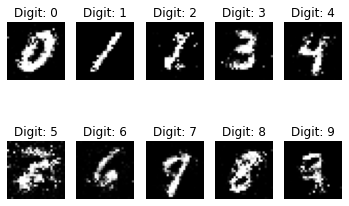

5801 [D loss: 0.681540, acc.: 57.81%] [G loss: 0.783871]
5802 [D loss: 0.632697, acc.: 65.62%] [G loss: 0.901759]
5803 [D loss: 0.715289, acc.: 46.88%] [G loss: 0.865637]
5804 [D loss: 0.691852, acc.: 50.00%] [G loss: 0.817382]
5805 [D loss: 0.668148, acc.: 51.56%] [G loss: 0.774597]
5806 [D loss: 0.681700, acc.: 54.69%] [G loss: 0.827372]
5807 [D loss: 0.666306, acc.: 57.81%] [G loss: 0.818556]
5808 [D loss: 0.649951, acc.: 60.94%] [G loss: 0.871495]
5809 [D loss: 0.606942, acc.: 62.50%] [G loss: 0.821738]
5810 [D loss: 0.673558, acc.: 59.38%] [G loss: 0.834134]
5811 [D loss: 0.655723, acc.: 59.38%] [G loss: 0.776118]
5812 [D loss: 0.697032, acc.: 57.81%] [G loss: 0.788679]
5813 [D loss: 0.665018, acc.: 56.25%] [G loss: 0.792827]
5814 [D loss: 0.642816, acc.: 56.25%] [G loss: 0.862655]
5815 [D loss: 0.643301, acc.: 59.38%] [G loss: 0.803423]
5816 [D loss: 0.663105, acc.: 60.94%] [G loss: 0.807940]
5817 [D loss: 0.656070, acc.: 68.75%] [G loss: 0.779064]
5818 [D loss: 0.711832, acc.: 5

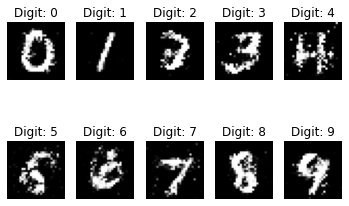

6001 [D loss: 0.599555, acc.: 71.88%] [G loss: 0.762334]
6002 [D loss: 0.645805, acc.: 68.75%] [G loss: 0.848876]
6003 [D loss: 0.654319, acc.: 54.69%] [G loss: 0.821083]
6004 [D loss: 0.598167, acc.: 60.94%] [G loss: 0.754308]
6005 [D loss: 0.699466, acc.: 46.88%] [G loss: 0.882465]
6006 [D loss: 0.653585, acc.: 53.12%] [G loss: 0.838550]
6007 [D loss: 0.677334, acc.: 60.94%] [G loss: 0.794603]
6008 [D loss: 0.654254, acc.: 57.81%] [G loss: 0.801735]
6009 [D loss: 0.735670, acc.: 48.44%] [G loss: 0.859285]
6010 [D loss: 0.597848, acc.: 67.19%] [G loss: 0.784635]
6011 [D loss: 0.616509, acc.: 64.06%] [G loss: 0.785742]
6012 [D loss: 0.646938, acc.: 53.12%] [G loss: 0.876278]
6013 [D loss: 0.691297, acc.: 53.12%] [G loss: 0.867640]
6014 [D loss: 0.635462, acc.: 62.50%] [G loss: 0.731838]
6015 [D loss: 0.685479, acc.: 54.69%] [G loss: 0.926245]
6016 [D loss: 0.634411, acc.: 59.38%] [G loss: 0.804600]
6017 [D loss: 0.697662, acc.: 53.12%] [G loss: 0.810887]
6018 [D loss: 0.680052, acc.: 5

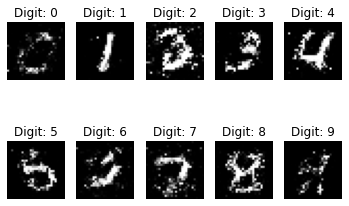

6201 [D loss: 0.675444, acc.: 53.12%] [G loss: 0.815658]
6202 [D loss: 0.695623, acc.: 51.56%] [G loss: 0.808683]
6203 [D loss: 0.689551, acc.: 57.81%] [G loss: 0.807974]
6204 [D loss: 0.691827, acc.: 59.38%] [G loss: 0.765769]
6205 [D loss: 0.693700, acc.: 53.12%] [G loss: 0.755326]
6206 [D loss: 0.693479, acc.: 48.44%] [G loss: 0.793393]
6207 [D loss: 0.681938, acc.: 53.12%] [G loss: 0.786972]
6208 [D loss: 0.663030, acc.: 56.25%] [G loss: 0.845259]
6209 [D loss: 0.662589, acc.: 54.69%] [G loss: 0.759020]
6210 [D loss: 0.656217, acc.: 60.94%] [G loss: 0.764529]
6211 [D loss: 0.680375, acc.: 57.81%] [G loss: 0.775344]
6212 [D loss: 0.673082, acc.: 53.12%] [G loss: 0.771599]
6213 [D loss: 0.686753, acc.: 48.44%] [G loss: 0.835945]
6214 [D loss: 0.692787, acc.: 56.25%] [G loss: 0.804196]
6215 [D loss: 0.711059, acc.: 53.12%] [G loss: 0.826779]
6216 [D loss: 0.663599, acc.: 62.50%] [G loss: 0.757100]
6217 [D loss: 0.667279, acc.: 51.56%] [G loss: 0.772089]
6218 [D loss: 0.640622, acc.: 5

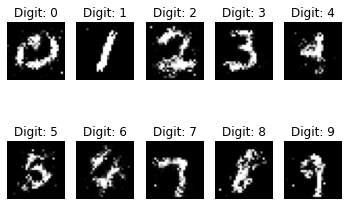

6401 [D loss: 0.628553, acc.: 57.81%] [G loss: 0.751748]
6402 [D loss: 0.685734, acc.: 45.31%] [G loss: 0.832871]
6403 [D loss: 0.700620, acc.: 45.31%] [G loss: 0.768339]
6404 [D loss: 0.679108, acc.: 62.50%] [G loss: 0.826916]
6405 [D loss: 0.653770, acc.: 60.94%] [G loss: 0.788349]
6406 [D loss: 0.699813, acc.: 46.88%] [G loss: 0.794310]
6407 [D loss: 0.696108, acc.: 42.19%] [G loss: 0.847637]
6408 [D loss: 0.692372, acc.: 48.44%] [G loss: 0.822250]
6409 [D loss: 0.666036, acc.: 51.56%] [G loss: 0.758943]
6410 [D loss: 0.639110, acc.: 57.81%] [G loss: 0.803126]
6411 [D loss: 0.711613, acc.: 50.00%] [G loss: 0.771352]
6412 [D loss: 0.690192, acc.: 57.81%] [G loss: 0.842281]
6413 [D loss: 0.669757, acc.: 57.81%] [G loss: 0.877816]
6414 [D loss: 0.678345, acc.: 56.25%] [G loss: 0.793540]
6415 [D loss: 0.682378, acc.: 46.88%] [G loss: 0.822100]
6416 [D loss: 0.691676, acc.: 57.81%] [G loss: 0.861565]
6417 [D loss: 0.635751, acc.: 60.94%] [G loss: 0.799240]
6418 [D loss: 0.671888, acc.: 5

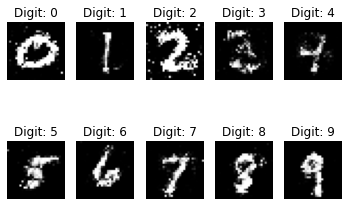

6601 [D loss: 0.671982, acc.: 59.38%] [G loss: 0.774105]
6602 [D loss: 0.663559, acc.: 57.81%] [G loss: 0.739162]
6603 [D loss: 0.676081, acc.: 51.56%] [G loss: 0.749381]
6604 [D loss: 0.651022, acc.: 64.06%] [G loss: 0.749222]
6605 [D loss: 0.660148, acc.: 68.75%] [G loss: 0.749898]
6606 [D loss: 0.653524, acc.: 57.81%] [G loss: 0.768469]
6607 [D loss: 0.636609, acc.: 65.62%] [G loss: 0.744413]
6608 [D loss: 0.701239, acc.: 48.44%] [G loss: 0.780327]
6609 [D loss: 0.682244, acc.: 56.25%] [G loss: 0.812332]
6610 [D loss: 0.680349, acc.: 60.94%] [G loss: 0.741856]
6611 [D loss: 0.665959, acc.: 56.25%] [G loss: 0.781973]
6612 [D loss: 0.709415, acc.: 56.25%] [G loss: 0.800084]
6613 [D loss: 0.675887, acc.: 54.69%] [G loss: 0.788024]
6614 [D loss: 0.662037, acc.: 60.94%] [G loss: 0.847173]
6615 [D loss: 0.653466, acc.: 62.50%] [G loss: 0.803284]
6616 [D loss: 0.732603, acc.: 50.00%] [G loss: 0.841564]
6617 [D loss: 0.647899, acc.: 54.69%] [G loss: 0.870960]
6618 [D loss: 0.647859, acc.: 5

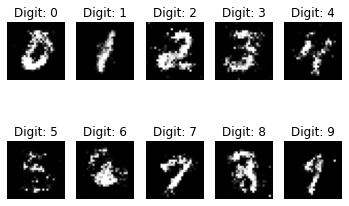

6801 [D loss: 0.687120, acc.: 51.56%] [G loss: 0.745860]
6802 [D loss: 0.661619, acc.: 57.81%] [G loss: 0.807111]
6803 [D loss: 0.679637, acc.: 50.00%] [G loss: 0.775852]
6804 [D loss: 0.679707, acc.: 48.44%] [G loss: 0.851940]
6805 [D loss: 0.640188, acc.: 59.38%] [G loss: 0.817971]
6806 [D loss: 0.662341, acc.: 59.38%] [G loss: 0.782657]
6807 [D loss: 0.704364, acc.: 59.38%] [G loss: 0.803554]
6808 [D loss: 0.654547, acc.: 53.12%] [G loss: 0.827355]
6809 [D loss: 0.708981, acc.: 53.12%] [G loss: 0.793445]
6810 [D loss: 0.678687, acc.: 60.94%] [G loss: 0.815660]
6811 [D loss: 0.659696, acc.: 62.50%] [G loss: 0.791388]
6812 [D loss: 0.635694, acc.: 54.69%] [G loss: 0.802144]
6813 [D loss: 0.662521, acc.: 64.06%] [G loss: 0.772622]
6814 [D loss: 0.639599, acc.: 62.50%] [G loss: 0.837751]
6815 [D loss: 0.645332, acc.: 62.50%] [G loss: 0.777898]
6816 [D loss: 0.637083, acc.: 62.50%] [G loss: 0.778247]
6817 [D loss: 0.696976, acc.: 54.69%] [G loss: 0.836952]
6818 [D loss: 0.660309, acc.: 5

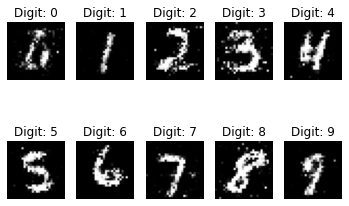

7001 [D loss: 0.668667, acc.: 62.50%] [G loss: 0.742404]
7002 [D loss: 0.666019, acc.: 59.38%] [G loss: 0.787921]
7003 [D loss: 0.715241, acc.: 53.12%] [G loss: 0.837510]
7004 [D loss: 0.644042, acc.: 67.19%] [G loss: 0.800074]
7005 [D loss: 0.653177, acc.: 56.25%] [G loss: 0.799621]
7006 [D loss: 0.694408, acc.: 53.12%] [G loss: 0.799944]
7007 [D loss: 0.657917, acc.: 59.38%] [G loss: 0.750701]
7008 [D loss: 0.647756, acc.: 65.62%] [G loss: 0.794865]
7009 [D loss: 0.690870, acc.: 57.81%] [G loss: 0.852948]
7010 [D loss: 0.692789, acc.: 56.25%] [G loss: 0.778108]
7011 [D loss: 0.640064, acc.: 60.94%] [G loss: 0.750749]
7012 [D loss: 0.663388, acc.: 57.81%] [G loss: 0.762249]
7013 [D loss: 0.700189, acc.: 54.69%] [G loss: 0.731474]
7014 [D loss: 0.664239, acc.: 60.94%] [G loss: 0.736168]
7015 [D loss: 0.690771, acc.: 56.25%] [G loss: 0.795256]
7016 [D loss: 0.661222, acc.: 57.81%] [G loss: 0.761357]
7017 [D loss: 0.697373, acc.: 59.38%] [G loss: 0.824600]
7018 [D loss: 0.663745, acc.: 5

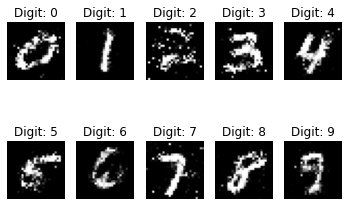

7201 [D loss: 0.671133, acc.: 60.94%] [G loss: 0.779160]
7202 [D loss: 0.680864, acc.: 53.12%] [G loss: 0.814737]
7203 [D loss: 0.688269, acc.: 67.19%] [G loss: 0.775033]
7204 [D loss: 0.674708, acc.: 48.44%] [G loss: 0.771933]
7205 [D loss: 0.658996, acc.: 56.25%] [G loss: 0.840679]
7206 [D loss: 0.644071, acc.: 54.69%] [G loss: 0.809231]
7207 [D loss: 0.700512, acc.: 48.44%] [G loss: 0.739563]
7208 [D loss: 0.687822, acc.: 46.88%] [G loss: 0.816188]
7209 [D loss: 0.666386, acc.: 50.00%] [G loss: 0.839453]
7210 [D loss: 0.680803, acc.: 62.50%] [G loss: 0.784480]
7211 [D loss: 0.653775, acc.: 57.81%] [G loss: 0.819062]
7212 [D loss: 0.660197, acc.: 64.06%] [G loss: 0.808788]
7213 [D loss: 0.689352, acc.: 45.31%] [G loss: 0.817589]
7214 [D loss: 0.701273, acc.: 59.38%] [G loss: 0.849206]
7215 [D loss: 0.666723, acc.: 59.38%] [G loss: 0.830541]
7216 [D loss: 0.650521, acc.: 53.12%] [G loss: 0.834517]
7217 [D loss: 0.684347, acc.: 51.56%] [G loss: 0.788346]
7218 [D loss: 0.681552, acc.: 5

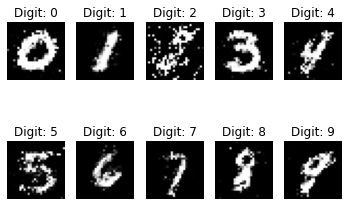

7401 [D loss: 0.680663, acc.: 57.81%] [G loss: 0.886897]
7402 [D loss: 0.663628, acc.: 56.25%] [G loss: 0.905529]
7403 [D loss: 0.651940, acc.: 56.25%] [G loss: 0.838076]
7404 [D loss: 0.651028, acc.: 60.94%] [G loss: 0.892403]
7405 [D loss: 0.657325, acc.: 54.69%] [G loss: 0.825270]
7406 [D loss: 0.670877, acc.: 51.56%] [G loss: 0.845245]
7407 [D loss: 0.674935, acc.: 59.38%] [G loss: 0.897994]
7408 [D loss: 0.667798, acc.: 53.12%] [G loss: 0.787084]
7409 [D loss: 0.660124, acc.: 57.81%] [G loss: 0.872126]
7410 [D loss: 0.637125, acc.: 59.38%] [G loss: 0.769567]
7411 [D loss: 0.668179, acc.: 59.38%] [G loss: 0.788814]
7412 [D loss: 0.659705, acc.: 54.69%] [G loss: 0.808426]
7413 [D loss: 0.673842, acc.: 53.12%] [G loss: 0.755293]
7414 [D loss: 0.648081, acc.: 59.38%] [G loss: 0.820143]
7415 [D loss: 0.674907, acc.: 57.81%] [G loss: 0.760426]
7416 [D loss: 0.699303, acc.: 43.75%] [G loss: 0.861221]
7417 [D loss: 0.655124, acc.: 54.69%] [G loss: 0.871791]
7418 [D loss: 0.698272, acc.: 5

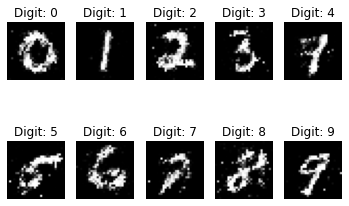

7601 [D loss: 0.672456, acc.: 59.38%] [G loss: 0.798746]
7602 [D loss: 0.647705, acc.: 60.94%] [G loss: 0.785943]
7603 [D loss: 0.675203, acc.: 59.38%] [G loss: 0.916275]
7604 [D loss: 0.698588, acc.: 54.69%] [G loss: 0.823067]
7605 [D loss: 0.680646, acc.: 48.44%] [G loss: 0.806276]
7606 [D loss: 0.689495, acc.: 50.00%] [G loss: 0.824691]
7607 [D loss: 0.681229, acc.: 59.38%] [G loss: 0.845694]
7608 [D loss: 0.689988, acc.: 57.81%] [G loss: 0.762614]
7609 [D loss: 0.647020, acc.: 59.38%] [G loss: 0.796952]
7610 [D loss: 0.678859, acc.: 56.25%] [G loss: 0.748526]
7611 [D loss: 0.667189, acc.: 56.25%] [G loss: 0.791188]
7612 [D loss: 0.661171, acc.: 60.94%] [G loss: 0.792062]
7613 [D loss: 0.669151, acc.: 59.38%] [G loss: 0.753618]
7614 [D loss: 0.693821, acc.: 51.56%] [G loss: 0.806837]
7615 [D loss: 0.657613, acc.: 57.81%] [G loss: 0.796360]
7616 [D loss: 0.667487, acc.: 51.56%] [G loss: 0.775266]
7617 [D loss: 0.727840, acc.: 50.00%] [G loss: 0.814827]
7618 [D loss: 0.637271, acc.: 7

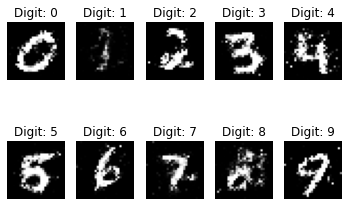

7801 [D loss: 0.671841, acc.: 57.81%] [G loss: 0.779129]
7802 [D loss: 0.621916, acc.: 62.50%] [G loss: 0.813858]
7803 [D loss: 0.684542, acc.: 46.88%] [G loss: 0.807830]
7804 [D loss: 0.689618, acc.: 56.25%] [G loss: 0.765062]
7805 [D loss: 0.650471, acc.: 59.38%] [G loss: 0.785732]
7806 [D loss: 0.645320, acc.: 59.38%] [G loss: 0.819692]
7807 [D loss: 0.682375, acc.: 56.25%] [G loss: 0.803590]
7808 [D loss: 0.696587, acc.: 46.88%] [G loss: 0.963370]
7809 [D loss: 0.655526, acc.: 56.25%] [G loss: 0.842962]
7810 [D loss: 0.718144, acc.: 46.88%] [G loss: 0.765194]
7811 [D loss: 0.628173, acc.: 59.38%] [G loss: 0.788016]
7812 [D loss: 0.681244, acc.: 45.31%] [G loss: 0.832326]
7813 [D loss: 0.625537, acc.: 59.38%] [G loss: 0.845813]
7814 [D loss: 0.644954, acc.: 60.94%] [G loss: 0.818011]
7815 [D loss: 0.685251, acc.: 53.12%] [G loss: 0.931658]
7816 [D loss: 0.700637, acc.: 53.12%] [G loss: 0.835809]
7817 [D loss: 0.669815, acc.: 56.25%] [G loss: 0.801615]
7818 [D loss: 0.688287, acc.: 5

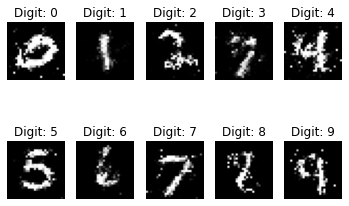

8001 [D loss: 0.675661, acc.: 54.69%] [G loss: 0.739628]
8002 [D loss: 0.672724, acc.: 54.69%] [G loss: 0.776851]
8003 [D loss: 0.695533, acc.: 53.12%] [G loss: 0.785225]
8004 [D loss: 0.681870, acc.: 57.81%] [G loss: 0.821416]
8005 [D loss: 0.698905, acc.: 48.44%] [G loss: 0.766087]
8006 [D loss: 0.629241, acc.: 65.62%] [G loss: 0.777422]
8007 [D loss: 0.726677, acc.: 42.19%] [G loss: 0.799677]
8008 [D loss: 0.658503, acc.: 56.25%] [G loss: 0.806049]
8009 [D loss: 0.689664, acc.: 53.12%] [G loss: 0.744656]
8010 [D loss: 0.697602, acc.: 46.88%] [G loss: 0.799453]
8011 [D loss: 0.669575, acc.: 57.81%] [G loss: 0.873991]
8012 [D loss: 0.675913, acc.: 62.50%] [G loss: 0.794600]
8013 [D loss: 0.709389, acc.: 48.44%] [G loss: 0.877516]
8014 [D loss: 0.718308, acc.: 50.00%] [G loss: 0.826598]
8015 [D loss: 0.661828, acc.: 60.94%] [G loss: 0.776706]
8016 [D loss: 0.654339, acc.: 62.50%] [G loss: 0.769878]
8017 [D loss: 0.680599, acc.: 50.00%] [G loss: 0.768971]
8018 [D loss: 0.667798, acc.: 5

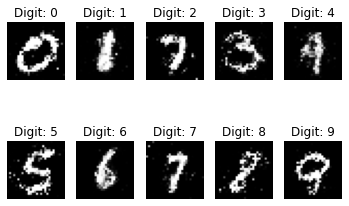

8201 [D loss: 0.678965, acc.: 51.56%] [G loss: 0.754593]
8202 [D loss: 0.677594, acc.: 51.56%] [G loss: 0.751713]
8203 [D loss: 0.651215, acc.: 60.94%] [G loss: 0.772677]
8204 [D loss: 0.686611, acc.: 56.25%] [G loss: 0.768928]
8205 [D loss: 0.647255, acc.: 51.56%] [G loss: 0.758862]
8206 [D loss: 0.633078, acc.: 59.38%] [G loss: 0.800463]
8207 [D loss: 0.664519, acc.: 59.38%] [G loss: 0.767643]
8208 [D loss: 0.673336, acc.: 57.81%] [G loss: 0.762230]
8209 [D loss: 0.676519, acc.: 50.00%] [G loss: 0.805921]
8210 [D loss: 0.670042, acc.: 54.69%] [G loss: 0.799485]
8211 [D loss: 0.668885, acc.: 56.25%] [G loss: 0.806574]
8212 [D loss: 0.649969, acc.: 67.19%] [G loss: 0.820758]
8213 [D loss: 0.651491, acc.: 67.19%] [G loss: 0.807133]
8214 [D loss: 0.607726, acc.: 64.06%] [G loss: 0.785496]
8215 [D loss: 0.663229, acc.: 53.12%] [G loss: 0.807299]
8216 [D loss: 0.630595, acc.: 64.06%] [G loss: 0.787998]
8217 [D loss: 0.688356, acc.: 50.00%] [G loss: 0.824566]
8218 [D loss: 0.680108, acc.: 5

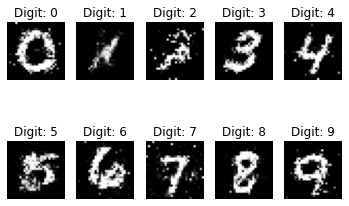

8401 [D loss: 0.633541, acc.: 59.38%] [G loss: 0.852146]
8402 [D loss: 0.667763, acc.: 62.50%] [G loss: 0.812457]
8403 [D loss: 0.655192, acc.: 57.81%] [G loss: 0.772826]
8404 [D loss: 0.648422, acc.: 62.50%] [G loss: 0.802014]
8405 [D loss: 0.665174, acc.: 54.69%] [G loss: 0.738408]
8406 [D loss: 0.706136, acc.: 48.44%] [G loss: 0.762048]
8407 [D loss: 0.675578, acc.: 46.88%] [G loss: 0.710938]
8408 [D loss: 0.697020, acc.: 51.56%] [G loss: 0.819416]
8409 [D loss: 0.647138, acc.: 57.81%] [G loss: 0.808214]
8410 [D loss: 0.671689, acc.: 54.69%] [G loss: 0.837770]
8411 [D loss: 0.660093, acc.: 60.94%] [G loss: 0.787993]
8412 [D loss: 0.680161, acc.: 59.38%] [G loss: 0.810933]
8413 [D loss: 0.631910, acc.: 62.50%] [G loss: 0.820899]
8414 [D loss: 0.656071, acc.: 56.25%] [G loss: 0.852070]
8415 [D loss: 0.663611, acc.: 57.81%] [G loss: 0.771361]
8416 [D loss: 0.666735, acc.: 50.00%] [G loss: 0.873377]
8417 [D loss: 0.633717, acc.: 59.38%] [G loss: 0.825476]
8418 [D loss: 0.673308, acc.: 5

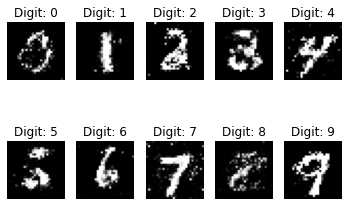

8601 [D loss: 0.707802, acc.: 53.12%] [G loss: 0.766811]
8602 [D loss: 0.680146, acc.: 45.31%] [G loss: 0.801193]
8603 [D loss: 0.647513, acc.: 64.06%] [G loss: 0.885953]
8604 [D loss: 0.658689, acc.: 53.12%] [G loss: 0.807241]
8605 [D loss: 0.612300, acc.: 65.62%] [G loss: 0.809280]
8606 [D loss: 0.655031, acc.: 65.62%] [G loss: 0.819088]
8607 [D loss: 0.676449, acc.: 57.81%] [G loss: 0.814267]
8608 [D loss: 0.686951, acc.: 50.00%] [G loss: 0.800567]
8609 [D loss: 0.643122, acc.: 62.50%] [G loss: 0.831859]
8610 [D loss: 0.662413, acc.: 51.56%] [G loss: 0.792550]
8611 [D loss: 0.634314, acc.: 62.50%] [G loss: 0.816846]
8612 [D loss: 0.678870, acc.: 53.12%] [G loss: 0.810865]
8613 [D loss: 0.618320, acc.: 65.62%] [G loss: 0.786362]
8614 [D loss: 0.669505, acc.: 51.56%] [G loss: 0.769118]
8615 [D loss: 0.639650, acc.: 57.81%] [G loss: 0.799223]
8616 [D loss: 0.622195, acc.: 54.69%] [G loss: 0.920015]
8617 [D loss: 0.678577, acc.: 51.56%] [G loss: 0.791297]
8618 [D loss: 0.655314, acc.: 5

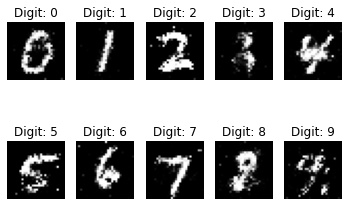

8801 [D loss: 0.697630, acc.: 54.69%] [G loss: 0.777531]
8802 [D loss: 0.669712, acc.: 57.81%] [G loss: 0.821695]
8803 [D loss: 0.648501, acc.: 53.12%] [G loss: 0.772448]
8804 [D loss: 0.682348, acc.: 56.25%] [G loss: 0.779572]
8805 [D loss: 0.664241, acc.: 53.12%] [G loss: 0.793991]
8806 [D loss: 0.694534, acc.: 60.94%] [G loss: 0.800771]
8807 [D loss: 0.653952, acc.: 57.81%] [G loss: 0.796117]
8808 [D loss: 0.677586, acc.: 59.38%] [G loss: 0.792567]
8809 [D loss: 0.660481, acc.: 54.69%] [G loss: 0.783517]
8810 [D loss: 0.670525, acc.: 56.25%] [G loss: 0.784893]
8811 [D loss: 0.684889, acc.: 51.56%] [G loss: 0.842512]
8812 [D loss: 0.672380, acc.: 54.69%] [G loss: 0.782507]
8813 [D loss: 0.677474, acc.: 54.69%] [G loss: 0.795133]
8814 [D loss: 0.699294, acc.: 46.88%] [G loss: 0.786593]
8815 [D loss: 0.626005, acc.: 56.25%] [G loss: 0.766994]
8816 [D loss: 0.678910, acc.: 53.12%] [G loss: 0.788726]
8817 [D loss: 0.687903, acc.: 53.12%] [G loss: 0.773821]
8818 [D loss: 0.671442, acc.: 5

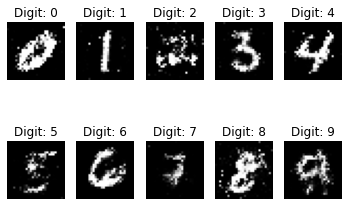

9001 [D loss: 0.660312, acc.: 57.81%] [G loss: 0.760110]
9002 [D loss: 0.674902, acc.: 53.12%] [G loss: 0.829533]
9003 [D loss: 0.677993, acc.: 40.62%] [G loss: 0.812796]
9004 [D loss: 0.623300, acc.: 59.38%] [G loss: 0.844846]
9005 [D loss: 0.699494, acc.: 53.12%] [G loss: 0.798042]
9006 [D loss: 0.651230, acc.: 60.94%] [G loss: 0.792634]
9007 [D loss: 0.705796, acc.: 56.25%] [G loss: 0.766688]
9008 [D loss: 0.666884, acc.: 53.12%] [G loss: 0.808030]
9009 [D loss: 0.644519, acc.: 54.69%] [G loss: 0.729860]
9010 [D loss: 0.640713, acc.: 62.50%] [G loss: 0.772508]
9011 [D loss: 0.663146, acc.: 59.38%] [G loss: 0.745477]
9012 [D loss: 0.695172, acc.: 51.56%] [G loss: 0.788874]
9013 [D loss: 0.649016, acc.: 59.38%] [G loss: 0.728781]
9014 [D loss: 0.667168, acc.: 64.06%] [G loss: 0.719295]
9015 [D loss: 0.701201, acc.: 51.56%] [G loss: 0.738390]
9016 [D loss: 0.681551, acc.: 53.12%] [G loss: 0.743541]
9017 [D loss: 0.687991, acc.: 59.38%] [G loss: 0.752162]
9018 [D loss: 0.692292, acc.: 5

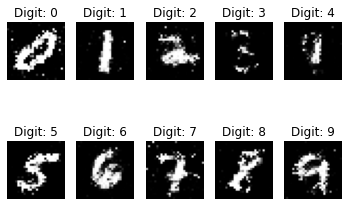

9201 [D loss: 0.672641, acc.: 54.69%] [G loss: 0.864242]
9202 [D loss: 0.674730, acc.: 57.81%] [G loss: 0.837191]
9203 [D loss: 0.637775, acc.: 62.50%] [G loss: 0.809662]
9204 [D loss: 0.600680, acc.: 67.19%] [G loss: 0.803006]
9205 [D loss: 0.689029, acc.: 54.69%] [G loss: 0.866040]
9206 [D loss: 0.686052, acc.: 54.69%] [G loss: 0.886482]
9207 [D loss: 0.698414, acc.: 57.81%] [G loss: 0.864444]
9208 [D loss: 0.677089, acc.: 57.81%] [G loss: 0.881174]
9209 [D loss: 0.615865, acc.: 70.31%] [G loss: 0.811658]
9210 [D loss: 0.683592, acc.: 57.81%] [G loss: 0.806385]
9211 [D loss: 0.725453, acc.: 43.75%] [G loss: 0.795742]
9212 [D loss: 0.699864, acc.: 53.12%] [G loss: 0.841841]
9213 [D loss: 0.665202, acc.: 57.81%] [G loss: 0.813986]
9214 [D loss: 0.672541, acc.: 56.25%] [G loss: 0.857277]
9215 [D loss: 0.662438, acc.: 48.44%] [G loss: 0.809314]
9216 [D loss: 0.684476, acc.: 54.69%] [G loss: 0.854097]
9217 [D loss: 0.694661, acc.: 60.94%] [G loss: 0.810162]
9218 [D loss: 0.708991, acc.: 4

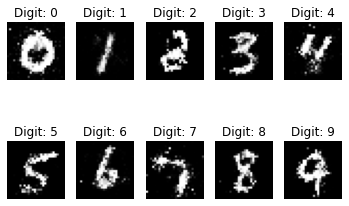

9401 [D loss: 0.637395, acc.: 65.62%] [G loss: 0.908025]
9402 [D loss: 0.645420, acc.: 53.12%] [G loss: 0.757421]
9403 [D loss: 0.663338, acc.: 59.38%] [G loss: 0.860640]
9404 [D loss: 0.629395, acc.: 62.50%] [G loss: 0.838926]
9405 [D loss: 0.717420, acc.: 45.31%] [G loss: 0.810327]
9406 [D loss: 0.637636, acc.: 57.81%] [G loss: 0.869064]
9407 [D loss: 0.702855, acc.: 53.12%] [G loss: 0.886631]
9408 [D loss: 0.687553, acc.: 46.88%] [G loss: 0.898268]
9409 [D loss: 0.675479, acc.: 57.81%] [G loss: 0.777019]
9410 [D loss: 0.645445, acc.: 56.25%] [G loss: 0.853088]
9411 [D loss: 0.687949, acc.: 56.25%] [G loss: 0.801315]
9412 [D loss: 0.682643, acc.: 56.25%] [G loss: 0.806522]
9413 [D loss: 0.607207, acc.: 62.50%] [G loss: 0.780667]
9414 [D loss: 0.685951, acc.: 53.12%] [G loss: 0.788471]
9415 [D loss: 0.636802, acc.: 54.69%] [G loss: 0.733625]
9416 [D loss: 0.675823, acc.: 53.12%] [G loss: 0.726597]
9417 [D loss: 0.656865, acc.: 56.25%] [G loss: 0.767360]
9418 [D loss: 0.668763, acc.: 5

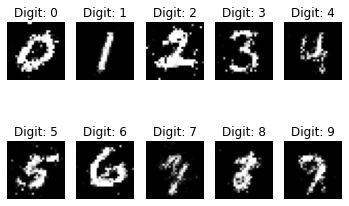

9601 [D loss: 0.642627, acc.: 57.81%] [G loss: 0.784761]
9602 [D loss: 0.657301, acc.: 60.94%] [G loss: 0.793311]
9603 [D loss: 0.650362, acc.: 53.12%] [G loss: 0.801163]
9604 [D loss: 0.675925, acc.: 59.38%] [G loss: 0.802583]
9605 [D loss: 0.651346, acc.: 59.38%] [G loss: 0.807102]
9606 [D loss: 0.674139, acc.: 54.69%] [G loss: 0.785678]
9607 [D loss: 0.649043, acc.: 62.50%] [G loss: 0.781265]
9608 [D loss: 0.670451, acc.: 62.50%] [G loss: 0.735210]
9609 [D loss: 0.677437, acc.: 53.12%] [G loss: 0.804051]
9610 [D loss: 0.620988, acc.: 68.75%] [G loss: 0.770587]
9611 [D loss: 0.694104, acc.: 42.19%] [G loss: 0.771602]
9612 [D loss: 0.657796, acc.: 57.81%] [G loss: 0.802950]
9613 [D loss: 0.631008, acc.: 59.38%] [G loss: 0.784724]
9614 [D loss: 0.656778, acc.: 56.25%] [G loss: 0.792404]
9615 [D loss: 0.682677, acc.: 65.62%] [G loss: 0.792320]
9616 [D loss: 0.624380, acc.: 65.62%] [G loss: 0.782591]
9617 [D loss: 0.663971, acc.: 64.06%] [G loss: 0.844804]
9618 [D loss: 0.670968, acc.: 5

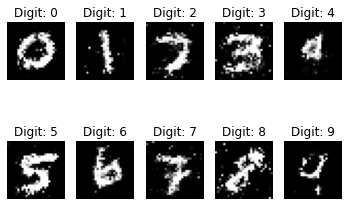

9801 [D loss: 0.664456, acc.: 59.38%] [G loss: 0.837699]
9802 [D loss: 0.675250, acc.: 57.81%] [G loss: 0.873636]
9803 [D loss: 0.651137, acc.: 56.25%] [G loss: 0.873294]
9804 [D loss: 0.701601, acc.: 46.88%] [G loss: 0.829378]
9805 [D loss: 0.659674, acc.: 60.94%] [G loss: 0.810106]
9806 [D loss: 0.668285, acc.: 56.25%] [G loss: 0.840043]
9807 [D loss: 0.640596, acc.: 65.62%] [G loss: 0.769171]
9808 [D loss: 0.649216, acc.: 64.06%] [G loss: 0.747101]
9809 [D loss: 0.647306, acc.: 57.81%] [G loss: 0.797832]
9810 [D loss: 0.677794, acc.: 54.69%] [G loss: 0.844264]
9811 [D loss: 0.664481, acc.: 53.12%] [G loss: 0.735621]
9812 [D loss: 0.665747, acc.: 56.25%] [G loss: 0.774729]
9813 [D loss: 0.705538, acc.: 50.00%] [G loss: 0.842029]
9814 [D loss: 0.635893, acc.: 60.94%] [G loss: 0.779649]
9815 [D loss: 0.680546, acc.: 54.69%] [G loss: 0.785024]
9816 [D loss: 0.652607, acc.: 62.50%] [G loss: 0.818817]
9817 [D loss: 0.647428, acc.: 57.81%] [G loss: 0.799245]
9818 [D loss: 0.708959, acc.: 5

In [ ]:
cgan = CGAN()
cgan.train(epochs=10000, batch_size=32, sample_interval=200)

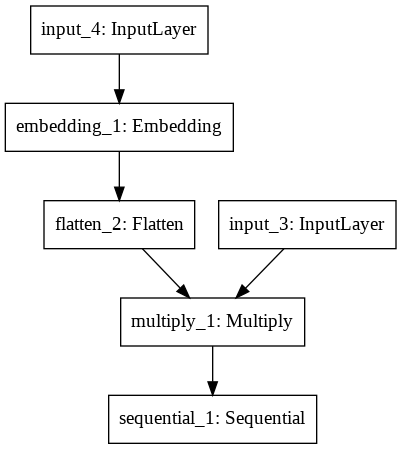

In [ ]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(cgan.generator)

In [ ]:
# D combined

In [ ]:
cgan.discriminator